# Fake News Detector

### Please run the cell below to install all your dependant packages.

In [ ]:
%pip install shap joblib nltk requests bs4 ipywidgets xgboost pandas numpy seaborn scikit-learn psycopg2-binary

### Please run the cell below to generate an input box. You must then input your article link and click 'Fetch Article'.

In [1]:
import ipywidgets as widgets
from IPython.display import display

# Create input widget
link_input = widgets.Text(
    placeholder='Enter article link',
    description='Link:',
)

# Create a button widget
fetch_button = widgets.Button(
    description='Fetch Article',
)

# Create a variable to store the link
article_link = None

# Define a function to save the link to the variable
def save_article_link(b):
    global article_link
    article_link = link_input.value

# Attach the function to the button click event
fetch_button.on_click(save_article_link)

# Display the widgets
display(link_input, fetch_button)


Text(value='', description='Link:', placeholder='Enter article link')

Button(description='Fetch Article', style=ButtonStyle())

### Run the cell below to see the title and article body

In [22]:
import requests
from bs4 import BeautifulSoup

# Define a function to fetch and process the article
def fetch_and_process_article():
    # Check if the article link has been provided
    if article_link is None:
        print("Please enter the article link and click 'Fetch Article' in the previous cell.")
        return
    
    try:
        # Fetch the article
        response = requests.get(article_link)
        soup = BeautifulSoup(response.text, "html.parser")
        
        # Find the title
        title_element = soup.find("h1")
        title = title_element.text if title_element else "Title not found"
        
        # Find the text content
        content_element = soup.find("p")
        text = content_element.text if content_element else "Text not found"
        
        # Display the results
        print(f"Title: {title}")
        print(f"Text: {text}")
    except Exception as e:
        print(f"Error: {e}")

# Call the function to fetch and process the article
fetch_and_process_article()


Title: 911 call released after fighter jet pilot ejects and lands in back garden: 'I'm not sure where the plane is'
Text: "We got a pilot in the house, and I guess he landed in my backyard," a baffled resident is heard telling the call handler. Military chiefs are unsure why the aircraft continued flying unmanned for 60 miles.


### Run the cell below to classify your article as REAL or FAKE

[04:03:51] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


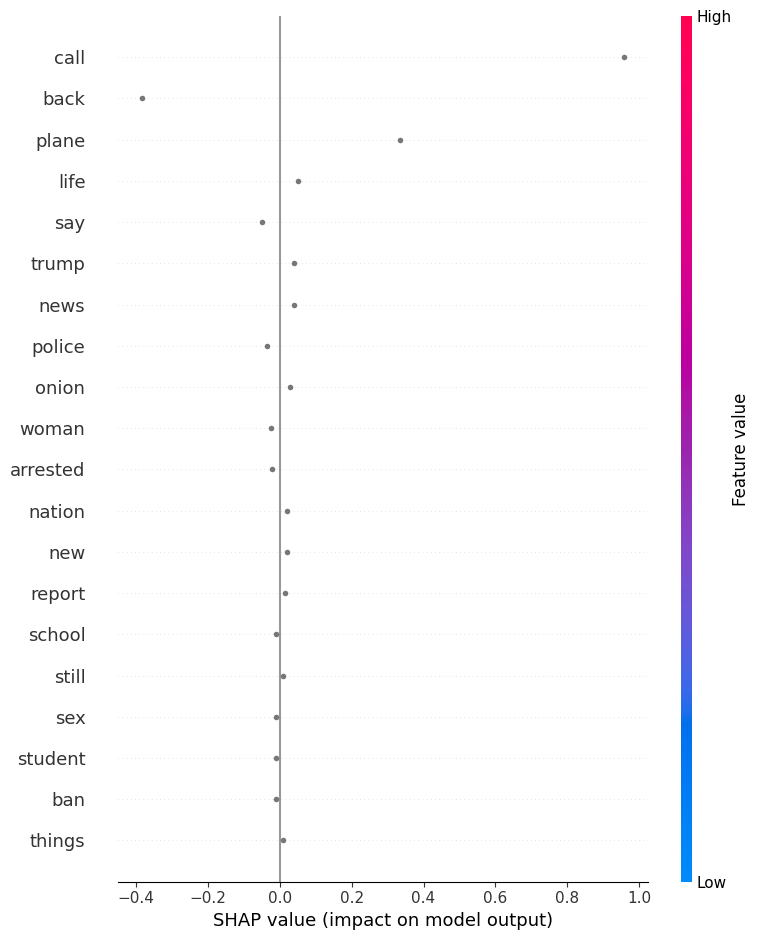

The article is classified as REAL with confidence score: 72.17%


In [23]:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import joblib
import xgboost
from sklearn.feature_extraction.text import TfidfVectorizer
import shap  # Add the SHAP library

# Fetch and process the article
def fetch_article(article_link):
    try:
        # Fetch the article
        response = requests.get(article_link)
        soup = BeautifulSoup(response.text, "html.parser")

        # Find the title
        title_element = soup.find("h1")
        title = title_element.text if title_element else "Title not found"

        return title
    except Exception as e:
        print(f"Error: {e}")
        return None, None

# Preprocess text using NLTK
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a single string
    preprocessed_text = " ".join(tokens)

    return preprocessed_text

# Load the saved vectorizer
vectorizer = joblib.load("tuned_vectorizer.pkl")

# Load classifier
classifier = joblib.load("tuned_xgboost_classifier.pkl")

# Create a SHAP explainer
explainer = shap.Explainer(classifier)

def classify_article(article_link, classifier):
    title = fetch_article(article_link)
    
    if title is not None:
        
        # Preprocess the article text
        preprocessed_article = preprocess_text(title)
        
        # Transform the input data using the same vectorizer
        input_tfidf = vectorizer.transform([preprocessed_article])
        
        # Predict using the classifier and get probability estimates
        prediction = classifier.predict(input_tfidf)
        probability = classifier.predict_proba(input_tfidf)
        
        # Convert the probability to a percentage
        confidence_percentage = probability[0][1] * 100
        
        # Output the prediction (0 for fake, 1 for real) along with confidence score as a percentage
        if prediction[0] == 0:
            result = f"The article is classified as FAKE with confidence score: {confidence_percentage:.2f}%"
        else:
            result = f"The article is classified as REAL with confidence score: {confidence_percentage:.2f}%"
        
        # Explain the prediction using SHAP values
        explanation = explainer.shap_values(input_tfidf)
        
        # Visualize feature contributions (you can customize this part)
        shap.summary_plot(explanation, input_tfidf, feature_names=vectorizer.get_feature_names_out())
        
        return result
    else:
        return "Article processing failed."

# Example usage
result = classify_article(article_link, classifier)
print(result)


### How to read this beeswarm plot

Grey Dots: The grey dots represent the SHAP values for individual features. Each dot corresponds to a feature, and its position on the x-axis represents the impact of that feature on the prediction. Dots to the left of 0.00 have a negative influence on the prediction, while dots to the right have a positive influence.

X-Axis (SHAP Values): The x-axis shows the SHAP values. Negative values on the left side indicate that the corresponding feature reduces the prediction score, while positive values on the right side indicate that the feature increases the prediction score.

Long Straight Line at 0.00: The long straight line at 0.00 on the x-axis represents the baseline prediction. This is the model's prediction when no features are considered. Features to the left of this line decrease the prediction relative to the baseline, while features to the right increase the prediction.

Vertical List of Words on the Left: This vertical list of words represents the features (words in this case) being considered. Each word is associated with a dot on the plot, showing its impact on the prediction. Features closer to the top of the list are more important in this specific prediction.

### Examples:

If the plot has the word 'Report' with a dot at -0.30, this means the presence of the word "Report" in the input text has a negative impact on the prediction. In this context, it reduces the prediction score by 0.30.

If the plot has the word 'Trump' with a dot at 0.05, this means the presence of the word "Trump" in the input text has a positive impact on the prediction. In this context, it increases the prediction score by 0.05.

Remember the classifier predicts 0 for fake and 1 for real.


### Please report errors and give feedback with the survey below: https://docs.google.com/forms/d/14txC7jPg_oWUkhhB9K2swznti8iAlps5o2UAVHqaYA0/edit